In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg
from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

import jax
import jax.numpy as jnp
import visualization
from data import standardize
from utils import results, experiments, settings, equioutput, evaluation, graphs
rng_key = jax.random.PRNGKey(0)
import os
import global_settings

In [4]:
result = results.ResultSample.load_from_file(
    # 1 hl, 3 hn
    #"/home/gw/data/experiments/master_thesis/results/1cd0fb4d70b0c0c9bc850afe49a45128.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/cbc8fa72832a535540fd3a72274bd1df.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/f542d3ebd37584291a4d8e9cef5b95f7.tar.gz"
    
    # 1 hl, 4 hn
    #"/home/gw/data/experiments/master_thesis/results/e99343eb8d643d1e9212b2fcab193df5.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/24b3fa55b428355bcb56dab1ae496025.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/c6835cefcab68b58b6f07158f1137c83.tar.gz"
    
    # 2 hl, 3 hn
    "/home/gw/data/experiments/master_thesis/results/3cd8dd0184d7cf6798001c36a05efb92.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/89478192c4d7fb7c0c138a6635f0ff04.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/3f20a27ee0828d865a36320f2af66afb.tar.gz"
    
    # 2 hl, 4 hn
    #"/home/gw/data/experiments/master_thesis/results/5fe59dd56f3ecc657fa49ac8b4ec4dce.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/f47e4647c414e39d47e2d5b79a59ce1e.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/ee1191f6065b8f88c88a62cffa269857.tar.gz"
    
    # 2 hl, 8hn
    #"/home/gw/data/experiments/master_thesis/results/37bccc0afc165ff842fbbeab926ab2f3.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/2afe0c254c0afa9dd1ba436f4be5affb.tar.gz"
    #"/home/gw/data/experiments/master_thesis/results/52a86ebd73aaa81538d2dccf80bd1b68.tar.gz"
    
    # 4 hl, 4 hn
    #"/home/gw/data/experiments/master_thesis/results/1664a41abb8c2042a3a316cefd1c5e87.tar.gz"
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
print(experiment._settings)

SettingsExperimentSample(output_path='/u/halle/wiese/home_at/data/experiments/master_thesis/results', dataset='sinusoidal', dataset_normalization='standardization', hidden_layers=2, hidden_neurons=3, activation='tanh', activation_last_layer='none', num_warmup=1024, statistic='reduced', statistic_p=0.99, samples_per_chain=1, identifiable_modes=3, pool_size=16, seed=0)


samples_parameters_fs.shape (1274, 22)


100%|█████████████████████████████████| 1024/1024 [00:10<00:00, 93.51it/s]


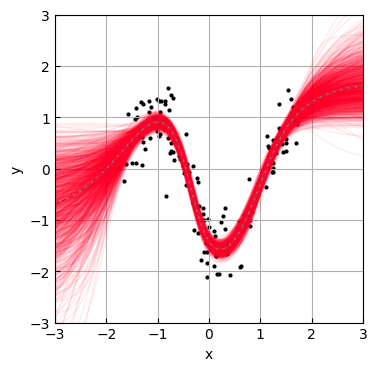

In [5]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))
samples_parameters_fs = jax.random.permutation(rng_key_, result.samples["parameters"])
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

In [6]:
# custom sh
sequential_helper = equioutput.SequentialHelper(
    transformation=experiment._model_transformation,
    dataset=experiment._dataset
)
structured_sequential_samples_parameters = sequential_helper.structured_sequential_samples_parameters(
    samples_parameters=result.samples["parameters"]
)
sh_custom = equioutput.SymmetryHelper(structured_sequential_samples_parameters)

# fixed sh
sh_fixed = equioutput.SymmetryHelperFixed(
    parameters_template=experiment._model_transformation.init(rng_key, experiment._dataset[0][0]),
    activation_function="tanh"
)

In [7]:
samples_parameters_mirrored = result.samples["parameters"]
samples_parameters_mirrored = sh_fixed.remove_tanh_symmetries(samples_parameters_mirrored, bias=True)
samples_parameters_mirrored = sh_fixed.remove_permutation_symmetries(samples_parameters_mirrored, bias=True)

samples_parameters_fs.shape (1274, 22)


100%|████████████████████████████████| 1024/1024 [00:07<00:00, 128.40it/s]


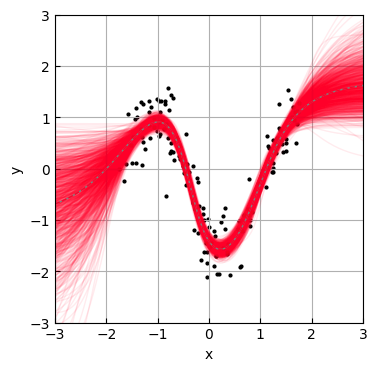

In [8]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))
samples_parameters_fs = jax.random.permutation(rng_key_, samples_parameters_mirrored)
print("samples_parameters_fs.shape", samples_parameters_fs.shape)

n = 2**10
if len(experiment._dataset.conditional_indices) > 1:
    n = 2**4

figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=0.08,
            epistemic=False
        )
    )
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[samples_parameters_fs[:n]],
    std=result.samples["std"].mean()
)

In [7]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "fs_full_posthoc.png"), bbox_inches="tight", dpi=96, transparent=True)

100%|█████████████████████████████████████| 22/22 [00:19<00:00,  1.13it/s]


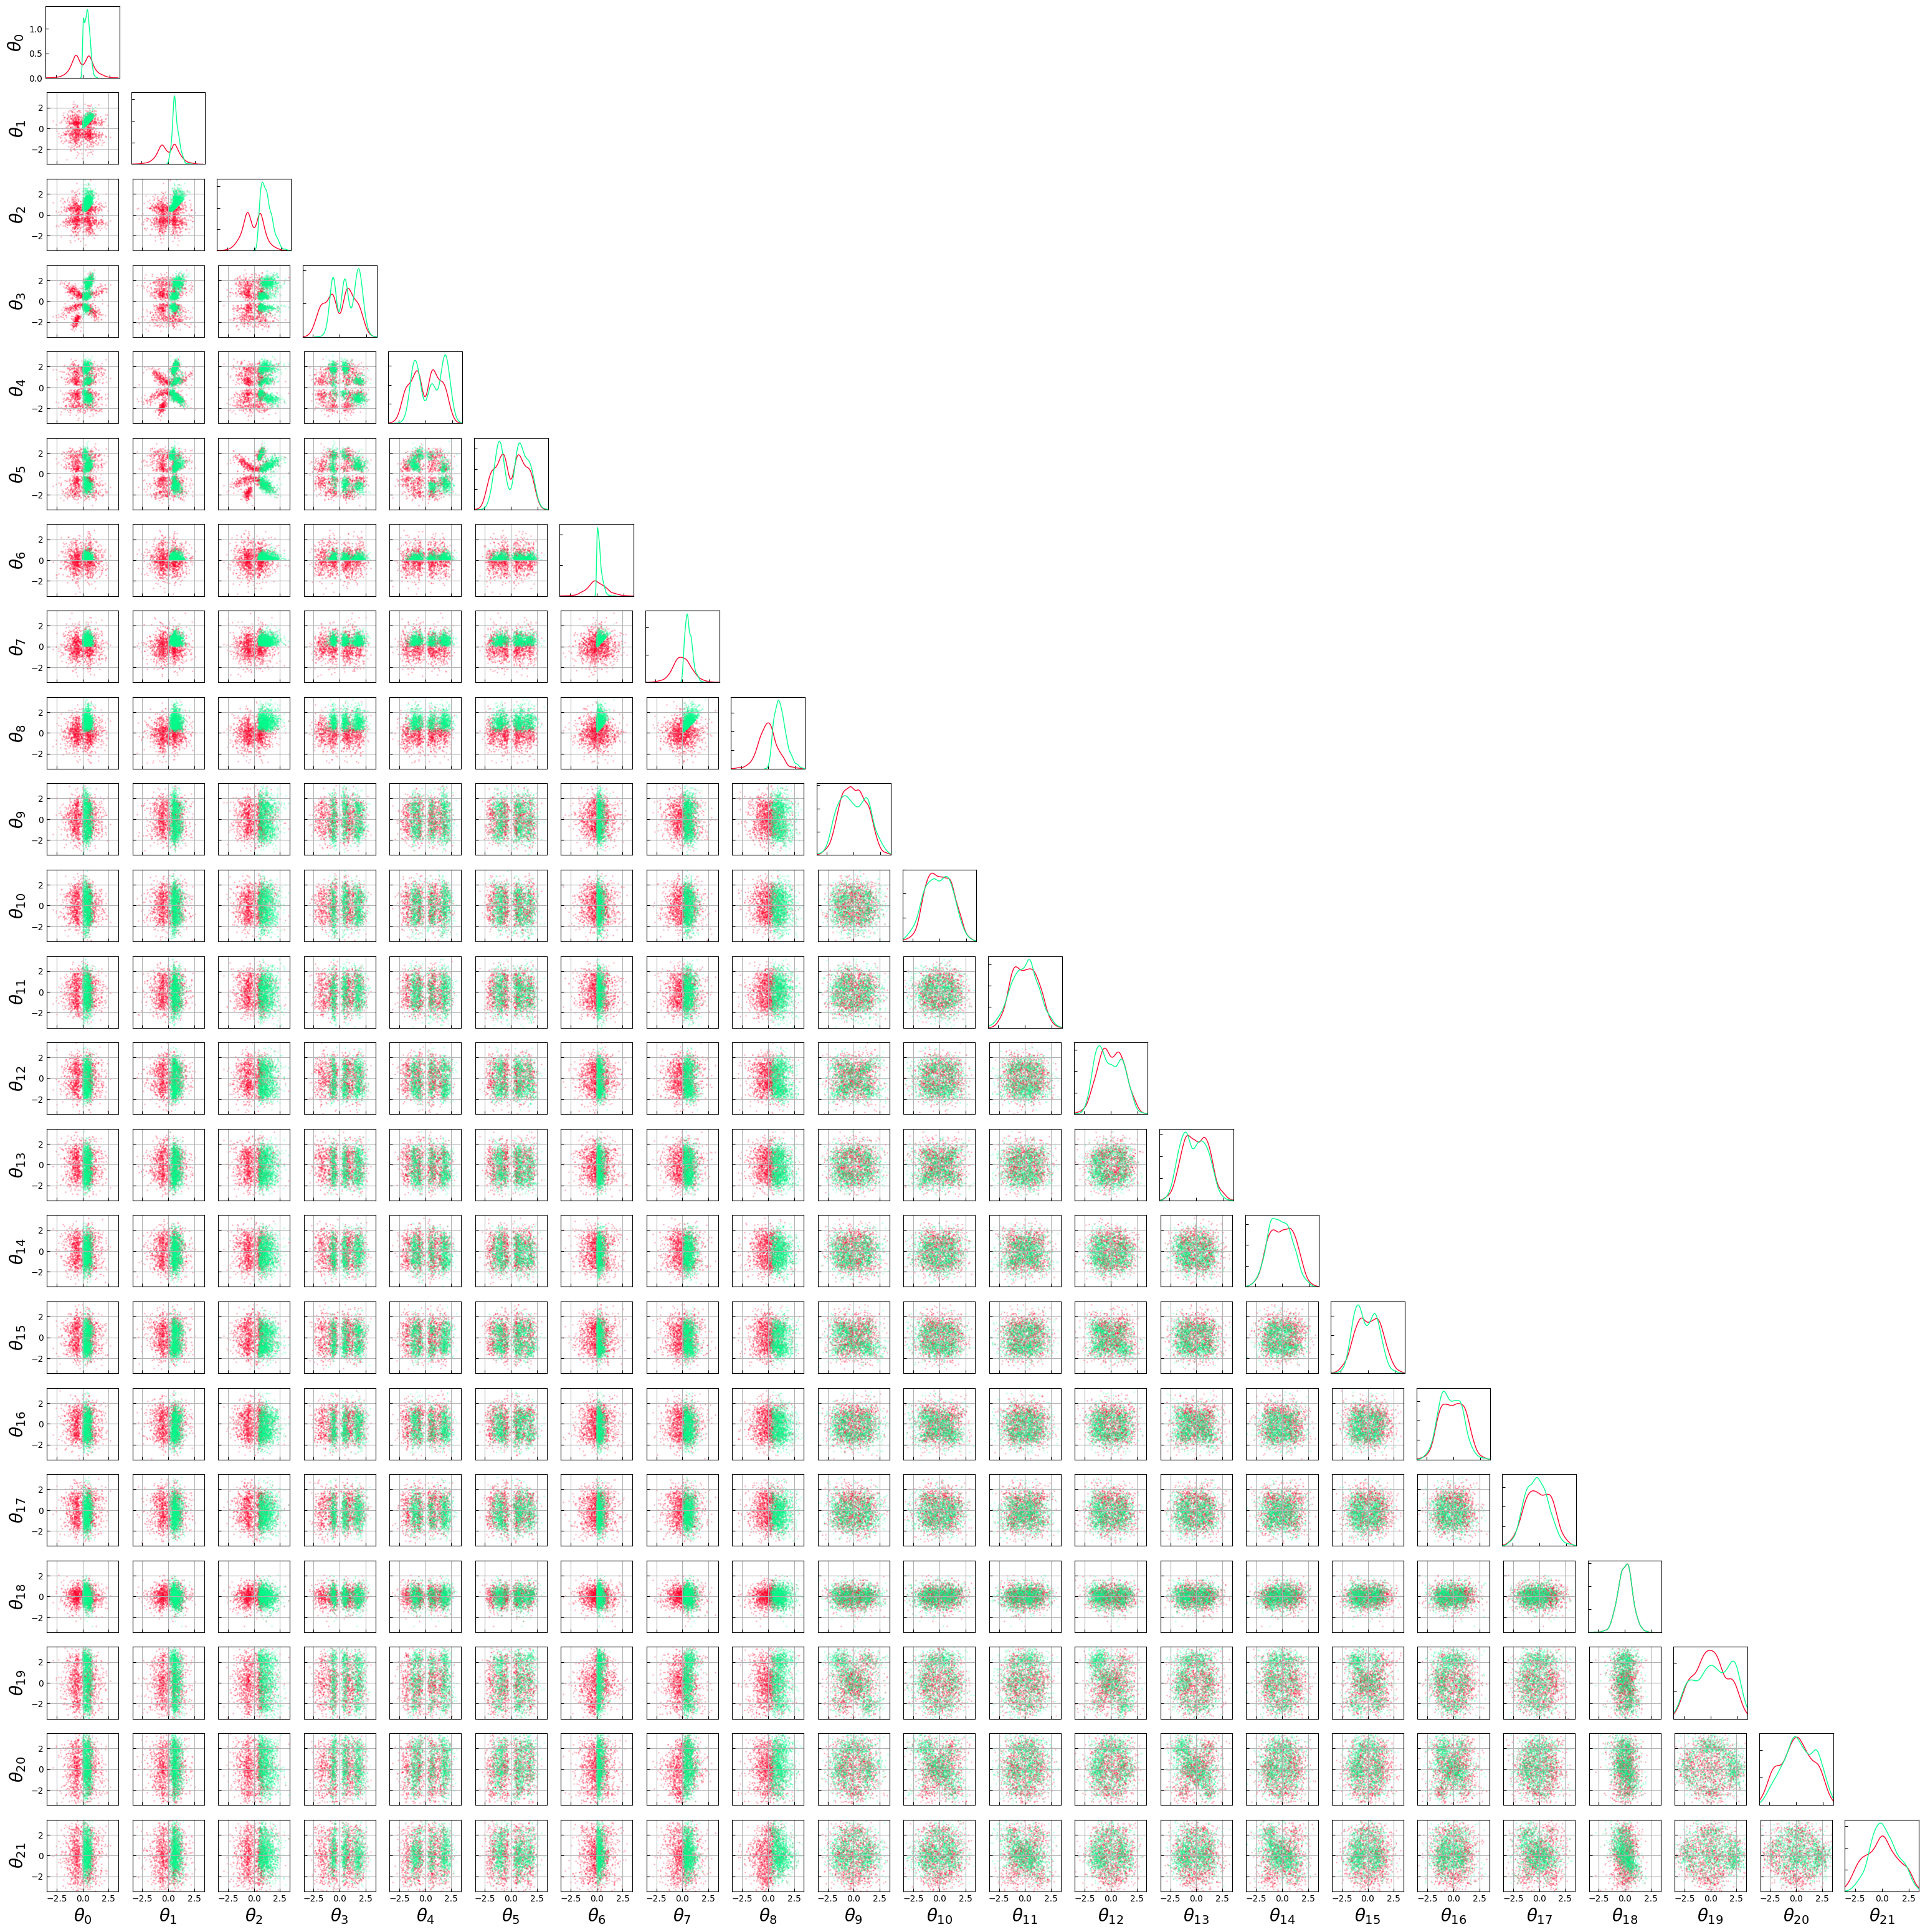

In [10]:
figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=[result.samples["parameters"], samples_parameters_mirrored],
    triangle="lower"
)

In [9]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "posterior_full_post_hoc.png"), bbox_inches="tight", dpi=96, transparent=True)

In [11]:
# custom sh reduced
sequential_helper_reduced = equioutput.SequentialHelper(
    transformation=experiment._model_transformation,
    dataset=experiment._dataset
)
structured_sequential_samples_parameters_reduced = sequential_helper_reduced.structured_sequential_samples_parameters(
    samples_parameters=samples_parameters_mirrored
)
sh_custom_reduced = equioutput.SymmetryHelper(structured_sequential_samples_parameters_reduced)

# subspaces
subspace_0 = sh_custom_reduced.hidden_layer_subspace(layer=0)

100%|███████████████████████████████████████| 5/5 [00:01<00:00,  4.48it/s]


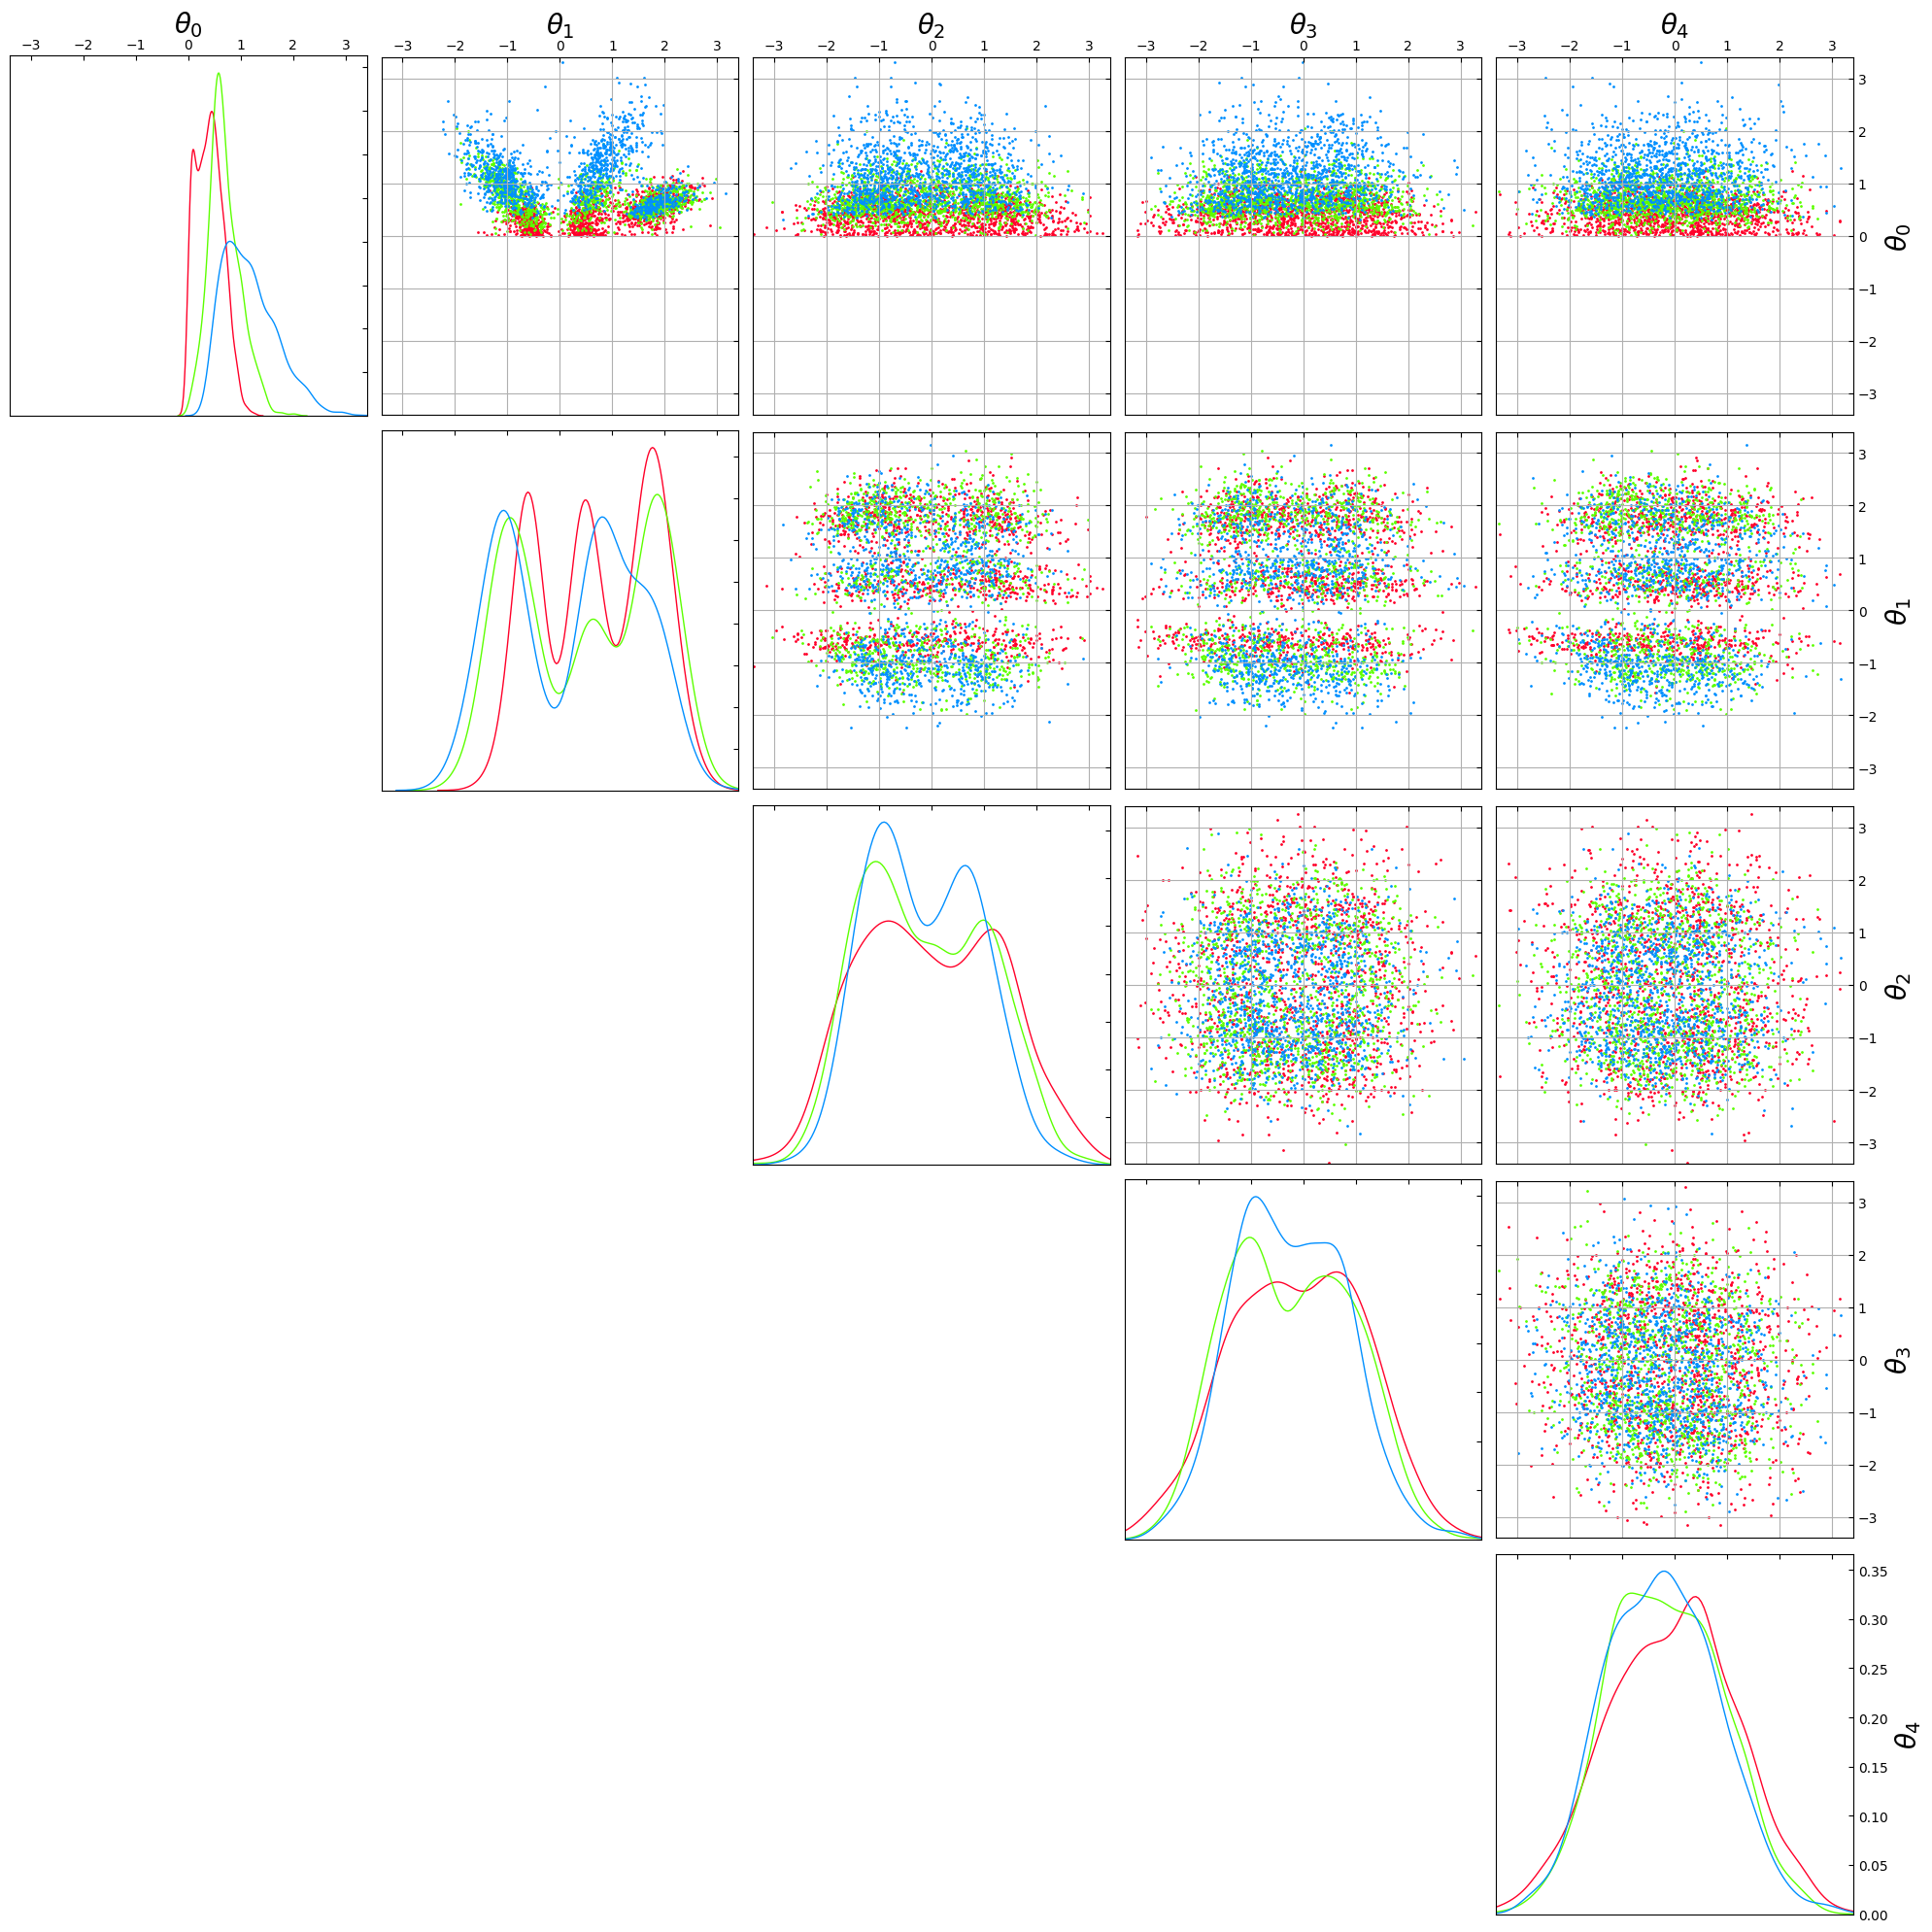

In [12]:
data_list = list(subspace_0.transpose(1, 0, 2))
figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        ax_width=4.0,
        ax_height=4.0,
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=1.0,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=data_list,
    triangle="upper"
)

In [12]:
figure._figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged_posthoc.png"), bbox_inches="tight", dpi=96, transparent=True)

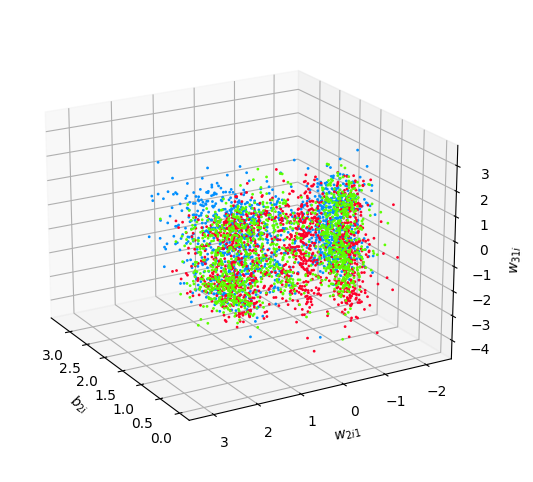

In [13]:
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.cm.get_cmap("gist_rainbow")

figure = plt.figure(figsize=(6, 6))
ax = figure.add_subplot(1, 1, 1, projection="3d")
for h in range(subspace_0.shape[-2]):
    color = cmap(1.0 * h / subspace_0.shape[-2])
    ax.scatter(subspace_0[:, h, 0], subspace_0[:, h, 1], subspace_0[:, h, 2], alpha=0.99, s=1, color=color)

#ax.scatter(0, 0, 0, alpha=0.99, s=100, c="black", marker='+')
#sample = 0
#ax.scatter(subspace_0[sample, 2, 0], subspace_0[sample, 2, 1], subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.scatter(-subspace_0[sample, 2, 0], -subspace_0[sample, 2, 1], -subspace_0[sample, 2, 2], alpha=0.99, s=100, color=color, marker='o')
#ax.plot(
#    [subspace_0[sample, 2, 0], -subspace_0[sample, 2, 0]],
#    [subspace_0[sample, 2, 1], -subspace_0[sample, 2, 1]],
#    [subspace_0[sample, 2, 2], -subspace_0[sample, 2, 2]], alpha=0.99, color=color)

ax.set_xlabel(r"$b_{2i}$")
ax.set_ylabel(r"$w_{2i1}$")
ax.set_zlabel(r"$w_{31i}$")

#ax.view_init(20, 210)
ax.view_init(20, 150)
figure

In [14]:
figure.savefig(os.path.join(global_settings.PATH_FIGURES, "neuron_subspace_merged_posthoc.png"), bbox_inches="tight", dpi=96, transparent=True)